# CP 2024-25: Assignment Lecture 4 - Numerical integration and numerical differentiation

### General Guidelines

> ⚠️⚠️⚠️ READ CAREFULLY ⚠️⚠️⚠️

- Do not add, delete or create cells, write the answer only in the space marked with the three dots (`...`). Where function skeletons are provided, it is assumed that that function can be called again with different inputs somewhere else. So be careful to write code outside of functions.
  - Function should be ['pure'](https://en.wikipedia.org/wiki/Pure_function), thus no side effects, unless otherwise specified.
- Run the the first cell to import all libraries when opening the notebook before running your own code.
- Read carefully what is required to be printed/returned/plotted in the answer. Please do not output what is not asked for. 
  - If you used the print function for debugging, comment it out ( Ctlr + / ) before submitting
- All plots should have title, xlabel, ylabel, and legend (if there are more than one curve on the plot)
- Use the `help()` function, consult python documentation when using new functions, or do a web search and consult [stackoverflow](https://stackoverflow.com/questions/tagged/python)
- Please read the error messages if you get any, and try to understand what they mean. Debugging code is an essential skill to develop.
- You can use `%debug` to start an IPython console in a cell (or a scratchpad cell!) after an exception has occurred to try to debug.
- You can use `%pdb` to toggle the Python DeBugger (pdb) auto start after an unhandled exception.
- In the assignments you will find some tests put in place, to help you verify your solution. If these fail you are certain you did something wrong, thus look at the hints they provide. But passing these tests does __not__ mean your solution is actually correct.

Make sure you use `python3.12` and the package versions as stated in the provided `requirements.txt`. This file should also be on the course page.

In [2]:
# Importing relevant libraries in the assignment

# This will create static plots (no zooming etc.)
# otherwise try just plain `%matplotlib`, or install a backend such as ipympl or PyQt5 and
# do or `%matplotlib ipympl` `%matplotlib qt`
%matplotlib inline

REPEAT_IMPORTS = True

if REPEAT_IMPORTS or ("IMPORTED_ALL" not in globals()):  # To save you a bit of time

    def print_import_info(package):
        print(
            "Successfully imported %-15s \tVersion: %10s"
            % (package.__name__, package.__version__)
        )

    ### Standard library imports

    import sys

    print("Python version {}".format(sys.version))
    if sys.version_info < (3, 12):
        print(
            "\u001b[31m"  # red
            "\u001b[1m"  # bold
            "WARNING: Use Python 3.12 or newer to not encounter any errors or "
            "problems later on.\n"
            "\u001b[0m"  # reset
        )
    del sys  # Do not need it anymore

    from typing import Callable

    ### Import third party libraries
    # Initialize self assessment helper
    import otter

    grader = otter.Notebook("Assignment_Q1_L4.ipynb")

    import numpy as np
    import pandas as pd

    print_import_info(np)
    import scipy

    print_import_info(scipy)
    import matplotlib
    import matplotlib.pyplot as plt

    print_import_info(matplotlib)

    IMPORTED_ALL = True
    print("Finished importing packages")
else:
    print("Already imported all packages")

PltAxes = matplotlib.axes.Axes | matplotlib.axes._axes.Axes
PlotType = tuple[
    matplotlib.figure.Figure,
    list[PltAxes],
]

Python version 3.12.10 (v3.12.10:0cc81280367, Apr  8 2025, 08:46:59) [Clang 13.0.0 (clang-1300.0.29.30)]
Successfully imported numpy           	Version:      2.3.2
Successfully imported scipy           	Version:     1.16.1
Successfully imported matplotlib      	Version:     3.10.5
Finished importing packages


## Part 1: Rigorous enthalpy computation (numerical integration)

The value of the entalphy of a given species $j$ at an arbitrary temperaure $T_{eval}$ can be computed according to the formula:
$$
\tilde{H}_j(T) = \tilde{H}_j^0 + \int_{T^0}^{T_{eval}} \tilde{c}_{p_j} dT
$$

Where:

- $\tilde{H}_j^0$ $[J/(kmol)]$ is the standard formation enthalpy of species $j$
- $\tilde{c}_{p_j}$ $[J/(kmol \cdot K)]$ is the specific molar heat capacity at constant pressure of species $j$ 
- ${T^0}$ is the Standard temperature ($298.15 K$)

$\tilde{c}_{p_j}$ is a quantity dependent on the temperature, thus we need to account for a function describing this relation. 

An example of it is the **Hyperbolic Function** for inorganic and organic compounds (Perry's Chemical Engineering Handbook - *Alias:* 'The Chemical Engineering Bible'):
$$
\tilde{c}_{p_j} = C1 + C2 \left[ \frac{C3/T}{sinh(C3/T)} \right]^2 + C4 \left[ \frac{C5/T}{cosh(C5/T)} \right]^2
$$

Here, the coefficients $C1$, $C2$, $C3$, $C4$, and $C5$ are dependent on the species $j$ and are regressed experimentally (we will talk about *Regression* in Q2 - Lecture 6).

In this example, we want to evaluate the specific enthalpy of carbon dioxide ($\text{CO}_2$) at $T_{eval} = 500K$. According to Perry's Chemical Engineering Handbook, the coefficients for carbon dioxide are the following:

- $C1 = 0.2937 \cdot 10^{5}$
- $C2 = 0.3454 \cdot 10^{5}$
- $C3 = 1.428 \cdot 10^{3}$
- $C4 = 0.264 \cdot 10^{5}$
- $C5 = 588$

Given the standard formation enthalpy of $\text{CO}_2$ equal to $-393.52 \: kJ/mol$, we can compute the difference given by the increment in temperature.

To achieve that we need to solve the following integral (*try to do it analytically!* ;)):
$$
\Delta H_j(T) = \tilde{H}_j(T) - \tilde{H}_j^0 =  \int_{T^0}^{T_{eval}} C1 + C2 \left[ \frac{C3/T}{sinh(C3/T)} \right]^2 + C4 \left[ \frac{C5/T}{cosh(C5/T)} \right]^2 dT
$$


In this exercise we will compute the enthalpy at a given temperature by using different numerical techniques and by performing the following steps: 

1. **Define the Hyperbolic Function for $c_p$ variation in Python**

2. **Implement the rectangle left method**

3. **Implement the rectangle right method**

4. **Implement the trapezoid method**

***Warning!:*** *throughout the whole assignment, please consider a fixed step size for domain discretization.*

***Warning! (pt.2):*** *throughout the whole assignment, when we ask to discretize a domain with extremes $[a,b]$ in $N$ points, the extremes $a$ and $b$ are **included** in the $N$ points.*

### Implementation details (1)
**Hyperbolic function for heat capacity**
   - Implement the function `cp_hyperbolic_function(temperature)`.
   - The function should take as input:
     - `temperature`: temperature of the system at which we evaluate the cp of carbon dioxide
   - The function should return the value of cp of CO2 `cp_CO2` at the given `temperature` according to the hyperbolic function.
   - Please use `numpy` to implement hyperbolic sine and hyperbolic cosine functions. Consult the numpy documentation to find the syntax.

In [3]:
def cp_hyperbolic_function(temperature: float) -> float:
    """Function returning the value of the cp of carbon dioxide at a given temperature

    Args:
        temperature (float): temperature of the system at which we evaluate the cp of carbon dioxide

    Returns:
        float: cp_CO2. The heat capacity at specified temperature
    """
    C1= 0.2937e5
    C2= 0.3454e5
    C3= 1.428e3
    C4= 0.264e5
    C5= 588

    term1 = ((C3/temperature)/np.sinh(C3/temperature))**2
    term2 = ((C5/temperature)/np.cosh(C5/temperature))**2

    cp_CO2 = C1 + C2*term1 + C4*term2


    return cp_CO2

In [4]:
grader.check("q1.1")

q1.1 results: All test cases passed!

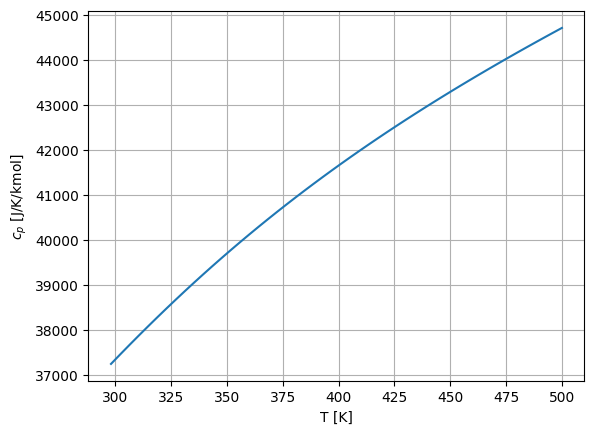

In [5]:
# Let's have a look at the function to be integrated
x_grid = np.linspace(298.15, 500)
fig, ax = plt.subplots()
ax.plot(x_grid, cp_hyperbolic_function(x_grid))
ax.set_xlabel("T [K]")
ax.set_ylabel("$c_p$ [J/K/kmol]")
ax.grid()

In [6]:
# Define discretization specs for numerical integration
a = 298.15  # left boundary
b = 500.0  # right boundary
n_points = 10  # number of grid points

### Implementation details (2)
**Rectangle method (left corner)**
   - Implement the function `rectangles_left(func, a, b, N)`.
   - The function should take as input:
     - `func`: the function to integrate
     - `a`: the start of the interval
     - `b`: the end of the interval
     - `N`: the number of points for the domain discretization
   - The function should return the integral of `func` over `[a, b]` by applying the left rectangle method for numerical integration, where the value of the function at the left end of each subinterval is used to approximate the area of the rectangle.

In [7]:
# Rectangles method for numerical integration (left corner)
def rectangles_left(func: Callable, a: float, b: float, N: int) -> float:
    """Function implementing a rectangle method for numerical integration

    Args:
        func (Callable): A function to be integrated
        a (float): Left domain boundary
        b (float): Right domain boundary
        N (int): Number of points for the domain discretization

    Returns:
        float: The value of the integral defined in the domain [a,b]
    """
    x = np.linspace(a,b,N)
    dx = x[1]-x[0]
    
    # the left corner method is the following:
    # I = sum(form 0 -> N-2) dx*x[i]
    integral = 0
    for i in range(0,N-1):
        integral += func(x[i])*dx
    return integral

In [8]:
grader.check("q1.2")

q1.2 results: All test cases passed!

In [9]:
# Compute the integral value using rectangles method (right corner)
integral_rl = rectangles_left(func=cp_hyperbolic_function, a=a, b=b, N=n_points)

print(f"The result of the integral defined in [{a},{b}] is {integral_rl/1000} $J/mol$")

The result of the integral defined in [298.15,500.0] is 8272.331889390523 $J/mol$


### Implementation details (3)
**Rectangle method (right corner)**
   - Implement the function `rectangles_right(func, a, b, N)`.
   - The function should take as input:
     - `func`: the function to integrate
     - `a`: the start of the interval
     - `b`: the end of the interval
     - `N`: the number of points for the domain discretization
   - The function should return the integral of `func` over `[a, b]` by applying the right rectangle method for numerical integration, where the value of the function at the right end of each subinterval is used to approximate the area of the rectangle.

In [10]:
# Rectangles method for numerical integration (right corner)
def rectangles_right(func: Callable, a: int, b: int, N:int)->float:
    """Right corner retangle integration method
    
    Inputs: 
    func    : Callable
        Input the function with needs to be integrated 
    a       : int 
        Start point
    b       : int 
        End point 
    N       : int 
            Number of points
            
    Returns:
    integration: float 
        the summation of individual rectangles
    """
 
    x = np.linspace(a,b,N)
    dx = x[1]-x[0]
    # dx = (b-a)/(N-1)          # this is the way that they have in the slides, however I think that both are the same so shouldnt matter

    # right corner method take the integration as x[i+1]
    integration = 0
    for i in range(0,N-1):
        integration += dx*func(x[i+1])

    return integration 

In [11]:
# Compute the integral value using rectangles method (right corner)

integral_rr = rectangles_right(cp_hyperbolic_function,a,b,n_points)
print(f"The result of the integral defined in [{a},{b}] is {integral_rr/1000} $J/mol$")

The result of the integral defined in [298.15,500.0] is 8439.782768315315 $J/mol$


In [12]:
grader.check("q1.3")

q1.3 results: All test cases passed!

### Implementation details (4)
   - Implement the function `composite_trapezoid(func, a, b, N)`.
   - The function should take as input:
     - `func`: the function to integrate
     - `a`: the start of the interval
     - `b`: the end of the interval
     - `N`: the number of points for the domain discretization
   - The function should return the integral of `func` over `[a, b]` by applying the trapezoid method for numerical integration, where each pair of adjacent points forms a trapezoid whose area is calculated and summed to find the total integral.

In [13]:
def composite_trapezoid(func: Callable,a:int,b:int,N:int)->float:
    """Integration composite triangle integrates the points as a triangle....
    
    Inputs:
    func        : Callable
        Function which needs to be integrated 
    a           : int 
        Initial boundary condition
    b           : int
        Final boundary condition
    N           : int
        Number of points 
    
    Returns:
    integration : float
        the summation of the different trapazoids 
        integration = (dx/2)*sum(y[i] + y[i+1])
 
    """
    x = np.linspace(a,b,N)
    dx = (b-a)/(N-1)

    integration = 0 
    for i in range(0,N-1):
        integration += (dx/2) * (func(x[i]) + func(x[i+1]))
    return integration 

In [14]:
# Compute the integral value using composite trapezoid

integral_tr = composite_trapezoid(cp_hyperbolic_function,a,b,n_points)

print(f"The result of the integral defined in [{a},{b}] is {integral_tr/1000} $J/mol$")

The result of the integral defined in [298.15,500.0] is 8356.05732885291 $J/mol$


In [15]:
grader.check("q1.4")

q1.4 results: All test cases passed!

### Reflect on the results
You got three different values for the enthalpy computed using three different numerical integration methods. 

In terms of magnitude, the computed enthalpy are:\
\
$ \text{enthalpy}_\text{RT} > \text{enthalpy}_\text{CT} > \text{enthalpy}_\text{LT} $

With:

- RT (Right Rectangle)
- CT (Composite Trapezoid)  
- LT (Left Rectangle)

Can you explain why you obtain this order? Which result would you choose in this case? (_Hint: Look at the integrand function_)


In the case of right rectangle, the method takes the right corner of the integrating rectangle and there for oversectimates the integration amount. 
(read left rectangle as it is more accurate, the same thing can be said about the right corner just vice versa)

Composite trapezoid method has a sloped top which slopes with the tangent of the curve, therefor being the most suitalbe out of the 3 methods for integrating the function. 


Left rectnagle matches the left corners of the rectangle with the curve, if you recall the cp_hyperbolic_function, aligning the left corners of the infinitely small rectangles will result in small deadspace which is not accounted for. This is what results in the slightly lower enthalpy. 

## Part 2: Plug Flow Reactor performance (numerical integration)
In this exercise, you will apply numerical integration techniques to solve the design equation for a Plug Flow Reactor (PFR). The design equation describes the relationship between the concentration of reactants and the reactor volume, and solving this equation is crucial for designing efficient chemical reactors.

**You will try to solve the following design problem:**

The rate of a homogeneous gas reaction $ A \rightarrow 3B$ was measured at $520K$ as:
$$
-r_A = kC_A^{1/2}   \quad    [\text{mol/liter} \cdot \text{s}]
$$
Here, the rate constant $k$ is 0.03 [-].

Find the space-time ($ \tau $) needed for **70% conversion** ($\Chi_{Af}$) of a feed constituted by 50% A and 50% inert reacting in a PFR operating at 520K and 5 atm ($ C_{A0} = 0.0625 \: \text{mol/liter}$).

*Recall: In a plug flow reactor (PFR), space-time is the time required for a volume of fluid to pass through the reactor, essentially representing the residence time for the reactants. It is calculated as the ratio of reactor volume $V$ to volumetric flowrate $F$. For a tubular PFR, the length can then be simply computed as $L = \tau F/A$.*

For this stoichiometry and with 50% inerts, two volumes of feed gas would give four volumes of completely converted product gas; thus, the expansion factor $\epsilon_A$ can be computed as:
$$
\epsilon_A = \frac{4-2}{2} = 1
$$

The space-time can be evaluated through the design equation for PFR:
$$
\tau = C_{A0} \int_0^{X_{f}} \frac{d \Chi_{A}}{-r_A}
$$

Specifically, for the described problem, the design equation becomes as follows:
$$
\tau = C_{A0} \int_0^{X_{Af}} \frac{d \Chi_{A}}{kC_{A0}^{1/2} \left( \frac{1-\Chi_{A}}{1+\epsilon_A\Chi_{A}} \right)^{1/2}} = \frac{C_{A0}^{1/2}}{k} \int_0^{0.7} \left( \frac{1+\Chi_{A}}{1-\Chi_{A}} \right)^{1/2} d \Chi_{A}
$$

### Numerical implementation: High level task description
In chemical engineering, many problems involve solving complex integrals, such as the design equation for a Plug Flow Reactor (PFR). These integrals often do not have analytical solutions, especially when dealing with real-world data and complex reaction kinetics.

Quadrature methods, such as Simpson's 1/3 rule, provide a way to approximate these integrals numerically. By discretizing the domain and using polynomial approximations, we can achieve accurate results that are essential for designing efficient chemical reactors. Numerical integration helps us solve the complex definite integrals, making it possible to find practical and usable solutions in engineering.

In this exercise we want to implement the Simpson's 1/3 Rule to solve the above-described problem. We will perform the 

1. **Implement Simpson's 1/3 Rule for a Single Interval**
   - Create a function `simpson` that computes the integral of a given function over a single interval [a, b] using Simpson's 1/3 rule.
   - Specific instructions, function prompt and docstring are given below

2. **Implement Composite Simpson's 1/3 Rule method**
   - Create a function `compositeSimpson` that applies the `simpson` function across a discretized grid to compute the integral over the entire domain.
   - Specific instructions, function prompt and docstring are given below

3. **Solve the PFR design equation**
   - Solve the given problem by making use of the Composite Simpson's 1/3 method you implemented. Discover what the necessary space-time $\tau$ is in order to achieve the desired conversion! :)

4. **Check your solution against an advanced built-in Python method for numerical integration**
   - You will use `scipy.integrate.quad` to solve the same integral using adaptive quadrature (i.e., adaptive varying step size).

### Implementation details (1)
**Simpson's 1/3 Rule for a Single Interval**
   - Implement the function `simpson(anyFunction, a, b)`.
   - The function should take as input:
     - `anyFunction`: the function to integrate
     - `a`: the start of the interval
     - `b`: the end of the interval
   - The function should return the integral `res` of `f` over [a, b] using Simpson's 1/3 rule.

In [16]:
def simpson(anyFunction: Callable, a: float, b: float) -> float:
    """Method that calculates the integral of a given function using the Simpson's 1/3 method

    Args:
        anyFunction (Callable): function of which integral is to be calculated
        a (float): the left integration boundary
        b (float): the right integration boundary

    Returns:
        float: integral of given function
    """
    # the equation for simpsons rule is: 
    # 1/3 * h * (func(a) + 4*func((b+a)/2) + func(b))
    
    dx = (b-a)/2
    res = dx/3 * (anyFunction(a) + 4*anyFunction((a+b)/2) + anyFunction(b))
    return res

In [17]:
grader.check("q2.1")

q2.1 results: All test cases passed!

### Implementation details (2)
**Composite Simpson's 1/3 method**
   - Implement the function `compositeSimpson(anyFunction, a, b, N)`.
   - The function should take as input:
     - `anyFunction`: the function to integrate
     - `a`: the start of the interval
     - `b`: the end of the interval
     - `N`: the number of points for the domain discretization (must be odd, greater or equal to 3)
   - The function should return the integral (as a float) of `anyFunction` over [a, b] by applying Simpson's 1/3 rule to each subinterval and summing them up --> Composite Simpson's 1/3 method.
   - The function should return none if the conditions on the number of discretization points is not met.

In [84]:
def compositeSimpson(anyFunction: Callable, a: float, b:float, N: int)-> float:
    """
    Integration method: Composite Simpson
    This method uses the following equation to calculate the integration of a function 'anyFunction':
        integration = h * 1/3 * (y[i] + 4* y[i+1] + y[i+2])
        this integration only works when N is less then 3 or N has to be devisable by 2: N%2==0
    
    Inputs: 
    anyFunction: Callable
        the function which you wish to integrate 
    a          : float 
        initial boundary condition 
    b          : float
        final boundary condition
    N          : int 
        Number of point for integration
    
    Returns:
    integration: float
        The summation of all integrations
    """
    
    if N < 3 or N %2 == 0:
        return None

    x = np.linspace(a,b,N)
    dx = (b-a)/(N-1)

    integration = 0
    for i in range(0,N-1,2):
        integration += (dx/3) * (anyFunction(x[i]) + 4 * anyFunction(x[i+1]) + anyFunction(x[i+2]))

    return integration



In [85]:
grader.check("q2.2")

q2.2 results: All test cases passed!

### Implementation details (3)
**Integrand function**
   - Implement the function `integrand_function(x)`, returning the value of the function to be integrated at a certain $\chi$:
  $$
  f(\chi) = \left(\frac{1+\chi}{1-\chi}\right)^{1/2}
  $$
   - The function should take as input:
     - `x`: the independent variable (i.e., the conversion)
   - The function should return the value of the integrand function evaluated at the given point `x`, as a float.

In [62]:
def integrand_function(x:float)->float:
    """the equation 
    
    Input: 
    x       : float
    
    Returns: 
    integral: float"""
    func = ((1+x)/(1-x))**(0.5)
    return func 

In [63]:
grader.check("q2.3")

q2.3 results: All test cases passed!

In [76]:
# Compute tau to achieve the desired conversion

final_conversion =  0.7
Ca0 = 0.0625
k = 0.03
integration_tau = compositeSimpson(integrand_function, 0, final_conversion, 31) 
tau = (np.sqrt(Ca0))/k * integration_tau
print(f"Space time for {final_conversion*100}% conversion is: {tau:.2f} seconds")

Space time for 70.0% conversion is: 8.84 seconds


In [77]:
grader.check("q2.4")

q2.4 results: All test cases passed!

### Implementation details (4)
**Use Python built-in functions**
Solve the integral above and calculate the residence time $\tau$ by using the built-in function `scipy.integrate.quad`. Check the documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html)!

Then, compare the solution with the one computed using your `compositeSimpson` function.


In [78]:
import scipy.integrate


integral_composite_simpson = integration_tau
integral_built_in = scipy.integrate.quad(integrand_function,0,final_conversion)[0]

In [79]:
grader.check("q2.5")

q2.5 results: All test cases passed!

In [80]:
tau_composite_simpson = tau
tau_built_in = (np.sqrt(Ca0)/k) * integral_built_in
absolute_difference = np.abs(tau_composite_simpson-tau_built_in)

print(
    f"The absolute difference between the results from your method and the built-in method is:\n{absolute_difference}"
)

The absolute difference between the results from your method and the built-in method is:
2.428495257333907e-06


In [81]:
grader.check("q2.6")

q2.6 results: All test cases passed!

## Part 3: Numerical differentiation - methods and errors
In this exercise, we explore the numerical approximation of the first-order derivative of a given function using three distinct finite difference methods: the **forward difference**, **backward difference**, and **central difference** schemes. The goal of the exercise is to compare the accuracy of these methods and understand how their errors depend on the step size used in the approximation.

To achieve this, we will:
- Implement the forward, backward, and central difference schemes as general functions.
- Apply these functions to a specific mathematical function $ f(x) = x^2 e^{x^2} \cos(x) \ln(x) $ over a specified domain.
- Compare the numerical derivatives obtained from each scheme with the analytical solution and analyze the error behavior as a function of the step size.
- Generate a plot showing the relationship between the step size and the average error, illustrating which method is more accurate.


In [86]:
def original_function(x):
    f = x**2 * np.exp(x**2) * np.cos(x) * np.log(x)
    return f

#### Implementation details 1: Forward Difference Scheme
The forward difference formula approximates the derivative of a function $ f(x) $ at a point $ x $ by calculating the difference between the function value at $ x + h $ and $ x $, divided by $ h $:
$$
f'(x) \approx \frac{f(x + h) - f(x)}{h}
$$

In [87]:
def forward_difference(f: Callable, x: float, h: float) -> float:
    """Function to compute the numerical derivative of a function using the forward difference method

    Args:
        f (Callable): function of which the derivative is to be calculated
        x (float): point at which the derivative is to be calculated
        h (float): step size

    Returns:
        float: numerical derivative of f at point x
    """
    return (f(x+h) - f(x))/h


In [88]:
grader.check("q3.1")

q3.1 results: All test cases passed!

#### Implementation details 2: Backward Difference Scheme
The forward difference formula approximates the derivative of a function $ f(x) $ at a point $ x $ by calculating the difference between the function value at $ x $ and $ x - h $, divided by $ h $:
$$
f'(x) \approx \frac{f(x) - f(x - h)}{h}
$$

In [89]:
def backward_difference(f: Callable, x: float, h: float) -> float:
    """Function to compute the numerical derivative of a function using the backward difference method

    Args:
        f (Callable): function of which the derivative is to be calculated
        x (float): point at which the derivative is to be calculated
        h (float): step size

    Returns:
        float: numerical derivative of f at point x
    """
    return (f(x) -f(x-h))/h

In [90]:
grader.check("q3.2")

q3.2 results: All test cases passed!

#### Implementation details 3: Central Difference Scheme
The central difference formula provides a more accurate approximation by considering the average rate of change between $ f(x + h) $ and $ f(x - h) $:

$$
f'(x) \approx \frac{f(x + h) - f(x - h)}{2h}
$$

In [91]:
def central_difference(f: Callable, x: float, h: float) -> float:
    """Function to compute the numerical derivative of a function using the central difference method

    Args:
        f (Callable): function of which the derivative is to be calculated
        x (float): point at which the derivative is to be calculated
        h (float): step size

    Returns:
        float: numerical derivative of f at point x
    """
    return (f(x+h) - f(x-h))/(2*h)

In [92]:
grader.check("q3.3")

q3.3 results: All test cases passed!

### Comparison and error evaluation

In the last part of the exercise, we calculate and plot the error of each numerical differentiation method (forward, backward, and central) over a domain $ x \in [1, 3] $. We compare the outcomes of numerical methods versus the (known) analytical solution. For a set of different grid step size $ h $, we:
- Compute the numerical derivative using the forward, backward, and central difference schemes at several points across the domain.
- Determine the absolute error at each point and compute the average error across the entire domain for each method and grid size.
- Plot the average error as a function of the grid step size $ h $.

**What the Code Shows:**
- **Central Difference is More Accurate**: The central difference method typically produces smaller errors compared to both forward and backward difference methods because it uses information from both sides of the point to estimate the derivative (the order of the error is $o(h^2)$, compared to $o(h)$ for forward and backward).
- **Error Decreases with Step Size**: As the grid step size $ h $ becomes smaller, the error decreases for all methods. This behavior is expected because a smaller step size provides a better approximation of the derivative.

**This part is already implemented for you. You can run the cell to see the results. However, please, try to read the code and the comments: it can be a useful refresh and you can learn something new!**

The analytical derivative is:

$$
f'(x) = x \left( 2x^2 \ln(x) \cos(x) - x \ln(x) \sin(x) + 2 \ln(x) \cos(x) + \cos(x) \right) e^{x^2}
$$

In [93]:
def analytical_derivative(x) -> float:
    """Function to compute the analytical derivative of a function

    Args:
        x (float): point at which the derivative is to be calculated

    Returns:
        float: analytical derivative of the function at point x
    """
    return (
        x
        * (
            2 * x**2 * np.log(x) * np.cos(x)
            - x * np.log(x) * np.sin(x)
            + 2 * np.log(x) * np.cos(x)
            + np.cos(x)
        )
        * np.exp(x**2)
    )

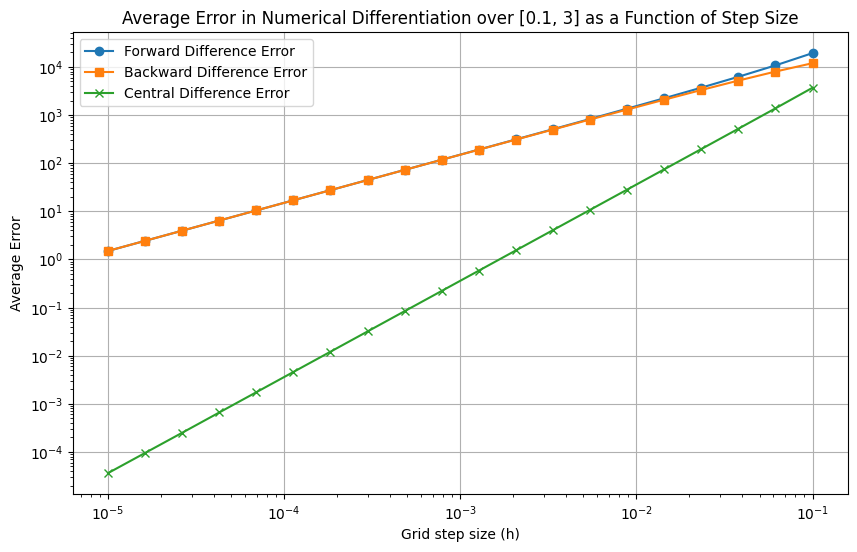

In [94]:
# Define the domain and grid sizes
x_values = np.linspace(
    1.0, 3.0, 100
)  # domain from 0.1 to 3, avoiding x=0 for log issues
h_values = np.logspace(-5, -1, 20)  # different grid sizes (in log scale!)

# Initialize arrays for storing average errors
forward_errors_avg = []
backward_errors_avg = []
central_errors_avg = []

# Loop through different grid sizes and calculate errors over the domain
for h in h_values:
    forward_errors = []
    backward_errors = []
    central_errors = []

    # Loop over the domain and calculate errors at each point
    for x in x_values:
        # Numerical derivatives
        fwd_diff = forward_difference(original_function, x, h)
        bwd_diff = backward_difference(original_function, x, h)
        ctr_diff = central_difference(original_function, x, h)

        # Analytical derivative
        exact_deriv = analytical_derivative(x)

        # Errors at this point
        forward_errors.append(np.abs(fwd_diff - exact_deriv))
        backward_errors.append(np.abs(bwd_diff - exact_deriv))
        central_errors.append(np.abs(ctr_diff - exact_deriv))

    # Compute the average error for the current grid size
    forward_errors_avg.append(np.mean(forward_errors))
    backward_errors_avg.append(np.mean(backward_errors))
    central_errors_avg.append(np.mean(central_errors))

# Plot the average errors as a function of the grid size (you can learn how to plot in log-scale!)
plt.figure(figsize=(10, 6))
plt.loglog(h_values, forward_errors_avg, label="Forward Difference Error", marker="o")
plt.loglog(h_values, backward_errors_avg, label="Backward Difference Error", marker="s")
plt.loglog(h_values, central_errors_avg, label="Central Difference Error", marker="x")
plt.xlabel("Grid step size (h)")
plt.ylabel("Average Error")
plt.title(
    "Average Error in Numerical Differentiation over [0.1, 3] as a Function of Step Size"
)
plt.legend()
plt.grid(True)
plt.show()

## Part 4: Determining thermal conductivity from experimental data (numerical differentiation)
In this exercise, you will apply numerical differentiation techniques to determine the thermal conductivity ($k$) of a material. This exercise simulates a real-world scenario where experimental temperature data is used to derive material properties.

The goal is to calculate the thermal conductivity of a rod subjected to a steady-state heat flux, using temperature measurements taken at various positions along its length.

Heat conduction in a steady state can be described by Fourier's law. For a one-dimensional rod, the temperature distribution $T(x)$ can be used to determine the temperature gradient, which in turn allows for the calculation of thermal conductivity. The governing equation is:
$$
q = -k \frac{dT}{dx}
$$
where:
- $q$ is the known heat flux entering the rod $[\text{W}/\text{cm}^2]$
- $k$ is the thermal conductivity $[\text{W}/(\text{cm} \cdot \text{\degree C})]$
- $\frac{dT}{dx}$ is the temperature gradient $[\text{\degree C}/\text{cm}]$

A rod of length $L = 10 \: \text{cm}$ is heated at one end to maintain a steady-state temperature distribution. The temperature $T(x)$ is measured at various positions $x$ along the rod, and the heat flux $q = 100 \: \text{W}/\text{cm}^2$ at the heated end is known and constant.

In practical experiments, measurement noise is inevitable and temperature readings can be affected by various factors. By measuring the temperature at multiple points along the rod, you can apply numerical differentiation at each point to estimate the temperature gradient. Calculating the thermal conductivity at these multiple points and then averaging the results helps mitigate the effect of noise and provides a more accurate and reliable estimate of the material's thermal conductivity.

### Numerical implementation
The experimental measurements are provided in a csv file called `temperature_data.csv`. You can open the file and explore the structure. Check online how you can load csv files using [Pandas](https://pandas.pydata.org/).
1. **Data loading**
   - Load the experimental measurements stored in `temperature_data.csv`.
   - Define a numpy array for position `x` and another for `temperature`, by extracting the data from the csv file. *hint*: you can open the file and see how it is structured, or you can load in Python and print it. 

2. **Numerical Differentiation**
   - Estimate the temperature gradient $\frac{dT}{dx}$ at each measurement point using finite difference methods.

3. **Thermal Conductivity Calculation**
   - Compute the thermal conductivity $k$ from the estimated temperature gradients and the known heat flux, for each point along the rod.
   - Average the results to obtain the final estimation of the average thermal conductivity (*hint: you can use* `np.mean()`)
   
   *Clarification:* you will compute a local thermal conductivity value for each point of the discretized domain (longitudinal axis of the grid). Then you just compute the mean of these values to obtain an average (estimation) of the thermal conductivity of the material.

In [107]:
# Data loading
data = pd.read_csv("/Users/oliverlohr/Documents/TUDelft/y1/q1/computational_practicum/redoing_assignments/assignment_4/temperature_data.csv")
x = data.iloc[:, 0].values          
temperature = data.iloc[:, 1].values  

# Given data
q = 100  # Heat flux in W/cm^2

In [108]:
grader.check("q4.1")

q4.1 results: All test cases passed!

### Implementation details (for part 2)
- Use central differences for interior points:
$$
\left.\frac{dT}{dx}\right|_{x_i} \approx \frac{T_{i+1} - T_{i-1}}{x_{i+1} - x_{i-1}}
$$

- Use forward difference for the first point:
$$
\left.\frac{dT}{dx}\right|_{x_1} \approx \frac{T_2 - T_1}{x_2 - x_1}
$$

- Use backward difference for the last point:
$$
\left.\frac{dT}{dx}\right|_{x_n} \approx \frac{T_n - T_{n-1}}{x_n - x_{n-1}}
$$

In [ ]:
# Calculate temperature gradients using central differences

import numpy as np


dT_dx = np.zeros_like(temperature)

# Forward difference for the first point
dT_dx[0] = (temperature[1] - temperature[0]) / (x[1] - x[0])

# Central differences for interior points
for i in range(1, len(temperature) - 1):
    dT_dx[i] = (temperature[i + 1] - temperature[i - 1]) / (x[i + 1] - x[i - 1])

# Backward difference for the last point
dT_dx[-1] = (temperature[-1] - temperature[-2]) / (x[-1] - x[-2])


In [129]:
grader.check("q4.2")

q4.2 results: All test cases passed!

In [132]:
# Regress thermal conductivity
k = -q * 1/dT_dx

# Average thermal conductivity
k_avg = np.mean(k)

# Output the results
print("Temperature Gradients:", dT_dx)
print("Thermal Conductivity at each point:", k)
print("Average Thermal Conductivity:", k_avg)

Temperature Gradients: [-4.11253328 -5.05514191 -3.69515602 -4.35033143 -5.06699487 -2.82588839]
Thermal Conductivity at each point: [24.31591263 19.78183831 27.06245672 22.98675439 19.7355637  35.38710177]
Average Thermal Conductivity: 24.87827125294379


In [133]:
grader.check("q4.3")

q4.3 results: All test cases passed!